# Проект

# Выбор локации для скважины

**Цель проекта:**

Определить регион с наибольшей прибылью от добычи нефти и наименьшей вероятностью убытков.

## Описание проекта

**Импорт библиотек.**

**Загрузка и подготовка данных**

Загружены данные по 3м регионам:
* Данные, типы данных соответствуют описанию. 
* Пропуски отсутствуют.
* Есть несколько дубликатов id - удалены.

Проведен исследовательский анализ данных:
* Описания признаков
* Гистограммы распределения
* Диаграммы размаха (выбросы сохранены)
* Тесты на нормальность распределения признаков
* Диаграмма рассеяния
* Корреляционный анализ признаков

Проведена подготовка данных для обучения модели:
* Определены тренировочная и тестовые выборки, входные и целевой признаки.
* Построен пайплайн для масштабирования признаков
* Модель: Линейная регрессия

**Обучение и проверка модели**

* Для каждого региона обучена модель линейной регрессии
* Получены предсказания целевого признака (объем запасов нефти, тыс. баррелей)
* Проведен анализ остатков
* Проведена работа по подбору признаков

**Подготовка к расчёту прибыли**

* Рассчитана точка безубыточности
* Определено количество скважин в каждом регионе, соответствующих точке безубыточности

**Расчёт прибыли и рисков**

* Создана функция для расчета прибыли
* Для каждого региона рассчитаа прибыль, доверительный интервал, вероятность убытков

**Общий вывод**

## Импорт библиотек

In [1]:
!pip install phik -q
#!pip install shap -q
#!pip install optuna -q
!pip install mlxtend -q
!pip install imbalanced-learn -q

In [2]:
#!pip install --upgrade scikit-learn -q # от падучей болезни Юпитера

In [3]:
import os
import math
import phik
#import shap
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import statsmodels.api as sm
#import matplotlib.colors as colors

In [4]:
from statsmodels.graphics.gofplots import qqplot
#from sklearn.feature_selection import f_classif, mutual_info_classif
#from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.linear_model import LogisticRegression, LinearRegression
#from optuna.integration import OptunaSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, r2_score, precision_score, recall_score, 
                             roc_auc_score, f1_score, make_scorer, mean_squared_error, mean_absolute_error)
from sklearn.impute import SimpleImputer
#from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
#from sklearn.svm import SVC
from matplotlib import pyplot as plt
#from optuna import distributions, visualization
#from imblearn import under_sampling, over_sampling
from scipy.stats import lognorm, shapiro, normaltest, anderson, uniform, pearsonr
from phik.report import plot_correlation_matrix
#from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures)
#from scipy.spatial.distance import (cosine, euclidean)
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.utils.class_weight import compute_class_weight
#from sklearn.feature_selection import SelectKBest
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.linear_model import LassoCV
#from sklearn.ensemble import RandomForestClassifier
#from imblearn.combine import SMOTETomek
from mlxtend.plotting import plot_decision_regions
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.tree import DecisionTreeRegressor
from itertools import combinations
from sklearn import tree
from phik import phik_matrix
from math import sqrt

In [5]:
from numpy.random import seed
from numpy.random import poisson
from scipy.stats import kstest

In [6]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [7]:
# Зададим отображение десятичных знаков

pd.options.display.float_format = '{:.3f}'.format

In [8]:
# Определим random_state и test_size

RANDOM_STATE = 43
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка данных

In [9]:
# Загружаем файлы с нужным разделителем

geo_data_0 = pd.read_csv(# путь к файлу, sep=','
    #, index_col='id').sort_values(by='id', ascending=True
)
geo_data_1 = pd.read_csv(# путь к файлу, sep=','
    #, index_col='id').sort_values(by='id', ascending=True
)
geo_data_2 = pd.read_csv(# путь к файлу, sep=','
    #, index_col='id').sort_values(by='id', ascending=True
)

#На случай загрузки данных из локальных папок:

pth1 = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv' pth2 = ''

if os.path.exists(pth1): query_1 = pd.read_csv(pth1) elif os.path.exists(pth2): query_1 = pd.read_csv(pth2) else: print('Something is wrong')

Выведем первые 5 строк каждого файла:

In [10]:
geo_data_0.head()

id     f0     f1    f2  product
0  txEyH  0.706 -0.498 1.221  105.280
1  2acmU  1.335 -0.340 4.365   73.038
2  409Wp  1.023  0.152 1.420   85.266
3  iJLyR -0.032  0.139 2.979  168.621
4  Xdl7t  1.988  0.155 4.752  154.037

In [11]:
geo_data_1.head()

id      f0      f1     f2  product
0  kBEdx -15.001  -8.276 -0.006    3.179
1  62mP7  14.272  -3.475  0.999   26.953
2  vyE1P   6.263  -5.948  5.001  134.766
3  KcrkZ -13.081 -11.506  4.999  137.945
4  AHL4O  12.702  -8.147  5.004  134.766

In [12]:
geo_data_2.head()

id     f0     f1     f2  product
0  fwXo0 -1.147  0.963 -0.829   27.759
1  WJtFt  0.263  0.270 -2.530   56.070
2  ovLUW  0.195  0.289 -5.586   62.872
3  q6cA6  2.236 -0.554  0.930  114.573
4  WPMUX -0.516  1.716  5.899  149.601

Данные в файлах соответствуют описанию

### Предобарботка данных

In [13]:
# Создадим список с файлами, названиями колонок, названиями файлов

# Список файлов
df_list=[geo_data_0, geo_data_1, geo_data_2]

# Названия колонок
col_names=geo_data_0.columns

# Названия файлов
df_names = ['geo_data_0', 'geo_data_1', 'geo_data_2']

Выведем общую информарцию о файлах.

In [14]:
for i, df in enumerate(df_list):
    print(f'{df_names[i]}')
    display(df.info())
    print('\n')

geo_data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None



geo_data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None



geo_data_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков нет, типы данных корректны.

In [15]:
# Проверим наличие полных дубликатов

for df in df_list:
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'Количество полных дубликатов в файле {df_name}: {df.duplicated().sum()}')

Количество полных дубликатов в файле geo_data_0: 0
Количество полных дубликатов в файле geo_data_1: 0
Количество полных дубликатов в файле geo_data_2: 0


Полных дубликатов нет.

In [16]:
# Проверим уникальные значения id

for df in df_list:
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'Число уникальных значений id в файле {df_name}: {df[df.duplicated(["id"])]["id"].count()}')

Число уникальных значений id в файле geo_data_0: 10
Число уникальных значений id в файле geo_data_1: 4
Число уникальных значений id в файле geo_data_2: 4


В каждом из 3-х файлов есть повторяющиеся id.

In [17]:
for i, df in enumerate(df_list):
    print(f'{df_names[i]}')
    display(df[df.duplicated(['id'], keep=False)].sort_values(by='id'))

geo_data_0


id     f0     f1     f2  product
66136  74z30  1.085 -0.312  6.991  127.643
64022  74z30  0.741  0.459  5.153  140.771
51970  A5aEY -0.180  0.936 -2.095   33.020
3389   A5aEY -0.040  0.157  0.210   89.249
69163  AGS9W -0.934  0.116 -3.656   19.230
42529  AGS9W  1.455 -0.480  0.683  126.371
931    HZww2  0.755  0.369  1.863   30.682
7530   HZww2  1.061 -0.374 10.430  158.829
63593  QcMuo  0.636 -0.473  0.863   64.579
1949   QcMuo  0.507 -0.324 -2.216   75.497
75715  Tdehs  0.112  0.430  3.219   60.964
21426  Tdehs  0.829  0.299 -0.050   96.035
92341  TtcGQ  0.111  1.023  0.911  101.318
60140  TtcGQ  0.569 -0.105  6.440   85.350
89582  bsk9y  0.399 -0.400 10.122  163.433
97785  bsk9y  0.378  0.006  0.161  160.637
41724  bxg6G -0.824  0.546  3.630   93.008
1364   bxg6G  0.412  0.857 -3.653   73.604
16633  fiKDv  0.157  1.028  5.586   95.818
90815  fiKDv  0.050  0.841  6.395  137.347

geo_data_1


id     f0      f1     f2  product
5849   5ltQ6 -3.435 -12.296  2.000   57.086
84461  5ltQ6 18.214   2.192  3.994  107.813
1305   LHZR0 11.171  -1.945  3.003   80.860
41906  LHZR0 -8.990  -4.287  2.009   57.086
2721   bfPNe -9.494  -5.464  4.006  110.992
82178  bfPNe -6.203  -4.820  2.995   84.039
47591  wt4Uk -9.091  -8.109 -0.002    3.179
82873  wt4Uk 10.260  -9.376  4.994  134.766

geo_data_2


id     f0     f1     f2  product
45404  KUPhW  0.232 -1.699  4.991   11.716
55967  KUPhW  1.211  3.176  5.544  132.832
11449  VF7Jo  2.123 -0.858  5.746  181.717
49564  VF7Jo -0.883  0.561  0.724  136.233
44378  Vcm5J -1.229 -2.439  1.223  137.968
95090  Vcm5J  2.588  1.987  2.482   92.328
28039  xCHr8  1.633  0.368 -2.378    6.121
43233  xCHr8 -0.847  2.102  5.597  184.389

Показатели скважин различны. В частности по самому "понятному" показателю - объем в баррелях, они сильно разнятся. 

Число повторов в общем объеме данных ничтожно. 

In [18]:
for i, df in enumerate(df_list):
    print(f'{df_names[i]}: min = {df["product"].min()}, max = {df["product"].max()}')

geo_data_0: min = 0.0, max = 185.3643474222929
geo_data_1: min = 0.0, max = 137.94540774090564
geo_data_2: min = 0.0, max = 190.0298383433513


Поскольку, не известно, что означают первые три показателя, и почему данные задвоились, сложно сказать, не удалим мы важные данные о месторождениях, удалив дубликаты.

Но, поскольку мы будем обучать модель, задвоенные и непонятные данные нам не нужны.

Хотя, количество их настолько мало, что если и оставить, сильно поменять ситуацию не должно.

Но, 
Пожалуй, удалю их. 

In [19]:
# Удалим дубликаты

geo_data_0 = geo_data_0.drop_duplicates(subset=['id'], keep='last')
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'], keep='last')
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'], keep='last')

In [20]:
df_list = [geo_data_0, geo_data_1, geo_data_2]

In [21]:
# Выводим информацию о файлах после удаления дубликатов

for i, df in enumerate(df_list):
    print(df_names[i])
    df.info()
    print('\n')

geo_data_0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


geo_data_1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


geo_data_2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 # 

In [22]:
# Проверим, если ли значения nan

for i, df in enumerate(df_list):
    print(df_names[i])
    for col in col_names:
         print(col, '\n', df[col].unique(), '\n')

geo_data_0
id 
 ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH'] 

f0 
 [0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393] 

f1 
 [-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676] 

f2 
 [ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937] 

product 
 [105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561] 

geo_data_1
id 
 ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0'] 

f0 
 [-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898] 

f1 
 [-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ] 

f2 
 [-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03] 

product 
 [  3.17910258  26.95326103 134.76630516 137.94540774  84.03888568
 110.99214671  53.90652206   0.         107.81304413  57.08562465
  30.13236361  80.85978309] 

geo_data_2
id 
 ['fwXo0' 'WJtFt' 'ovLUW' ... 'tK

Судя по всему, таких нет.

**Вывод:**

Данные в файлах соответствуют описанию (хоть и "неважно, что они означают"), типы данных корректны, пропусков нет.

Однако было выявлено несколько дубликатов id: 10-4-4 в 3-х файлах соотв-но. Дубликаты были удалены.

### Исследовательский анализ данных

In [23]:
# Создадим функцию для подписей графика и осей (пригодится позже)

def plot_lables(title, x, y):
    axs.set_title(title, fontsize=14)
    axs.set_xlabel(x, fontsize=12)
    axs.set_ylabel(y, fontsize=12)

Поскольку не понятно, что означают показатели в первых 3-х колонках, их описание ясности не внесет. Рассмотрим показаетли баррелей по 3м месторождениям.

In [24]:
# Выведем описание данных

for i, df in enumerate(df_list):
    print(df_names[i])
    display(df['product'].describe())

geo_data_0


count   99990.000
mean       92.499
std        44.289
min         0.000
25%        56.497
50%        91.850
75%       128.564
max       185.364
Name: product, dtype: float64

geo_data_1


count   99996.000
mean       68.825
std        45.945
min         0.000
25%        26.953
50%        57.086
75%       107.813
max       137.945
Name: product, dtype: float64

geo_data_2


count   99996.000
mean       95.000
std        44.748
min         0.000
25%        59.452
50%        94.926
75%       130.591
max       190.030
Name: product, dtype: float64

3-е месторождение показывает наибольшее число баррелей, 2-е - наименьшее. 

Средние показатели составляют по порядку рассматриваемых файлов: 92-68-95 баррелей, максимальные: 185-137-190.

При этом 25% скаважин содержат 56-26-59 баррелей, 50%: 91-57-94 баррелей (2е месторождение показывает результаты в 2 раза меньше, чем остальные), 75%: 128-107-130.

Выведем в общем виде гистораммы распределения признаков

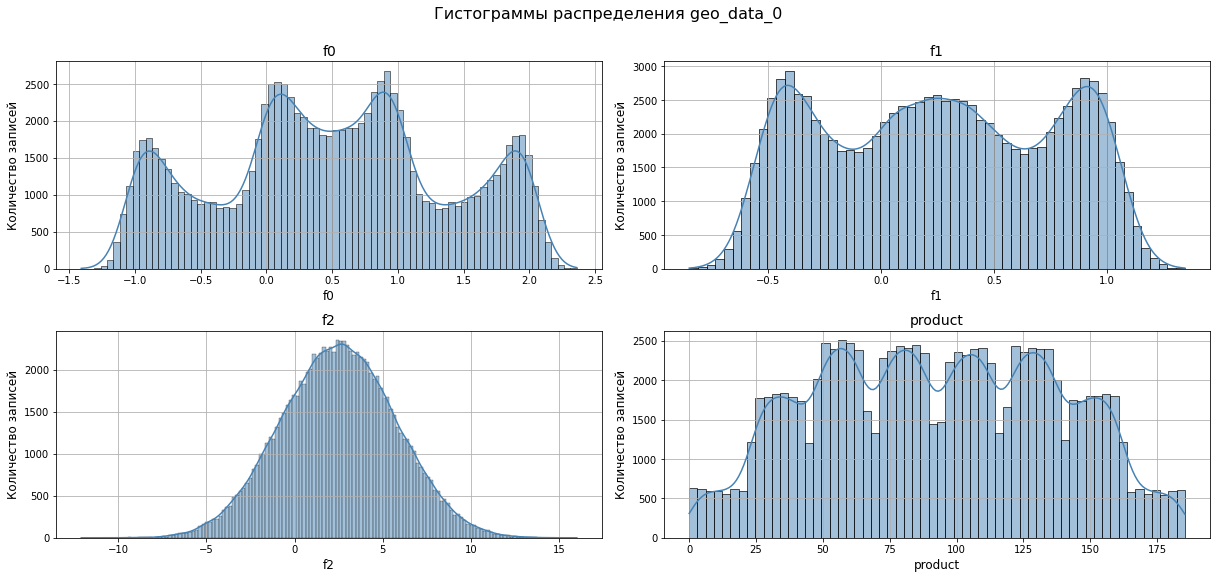

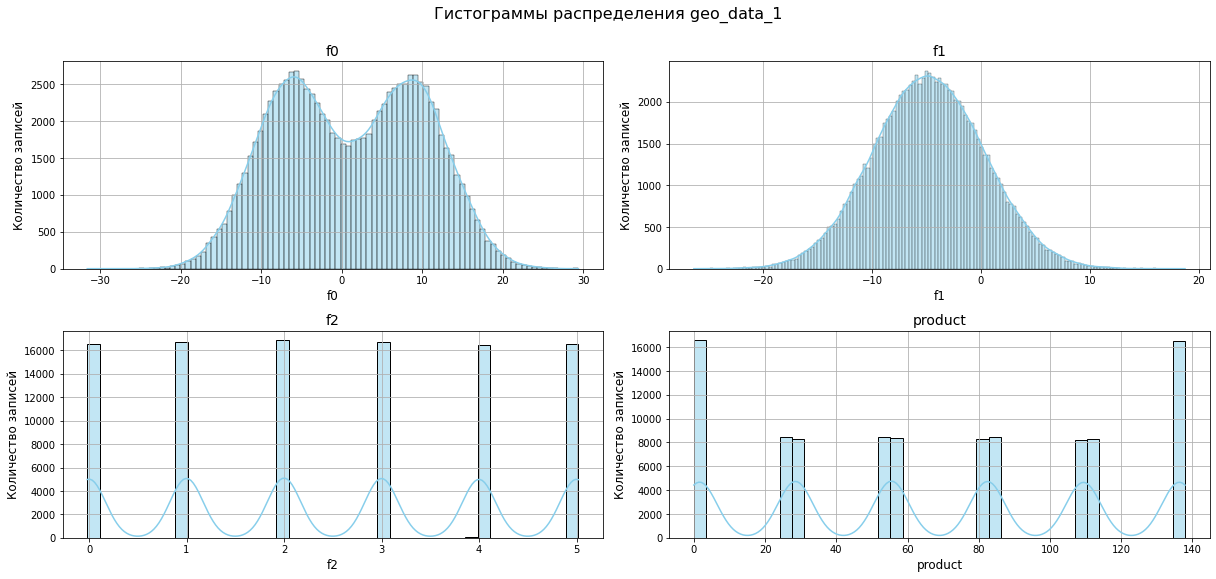

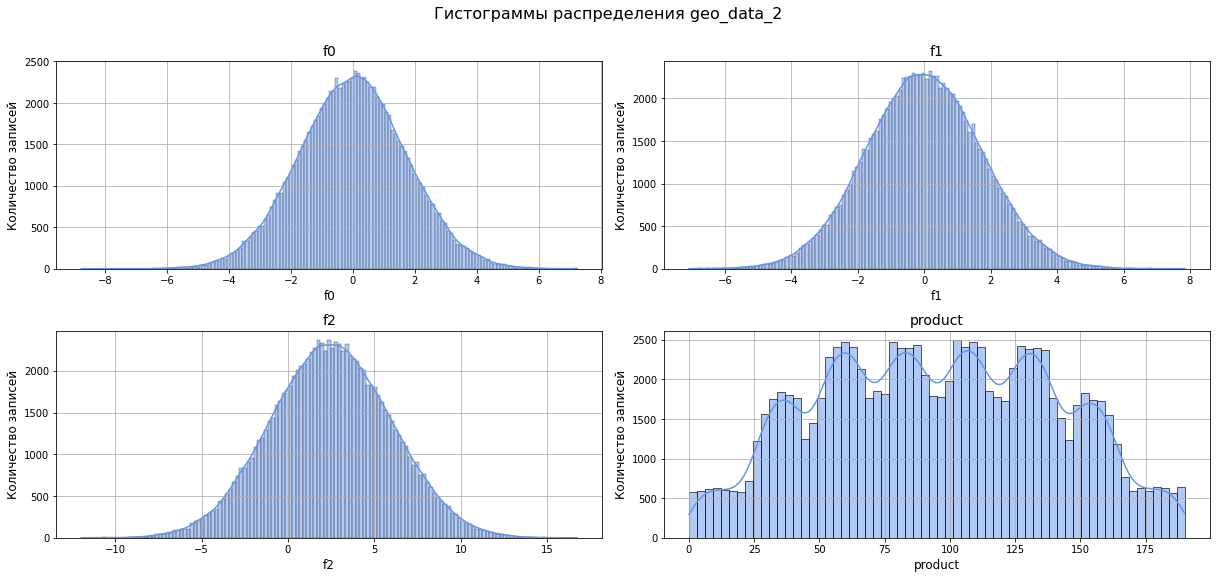

In [25]:
# Гистограммы распределения признаков

# Названия графиков
plot_titles = [ 'f0', 'f1', 'f2', 'product']

# Подписи для осей X и Y
x_labels =  [ 'f0', 'f1', 'f2', 'product']
y_labels = ['Количество записей']*4

# Признаки
features = ['f0', 'f1', 'f2', 'product']

color=['SteelBlue', 'SkyBlue', 'CornFlowerBlue']
# Используем циклы для построения гистограмм каждого признака

for j, df in enumerate(df_list):
    fig, axs = plt.subplots(2, 2, figsize=(17, 8))
    axs = axs.flatten()
    fig.suptitle(f'Гистограммы распределения {df_names[j]}', size=16, y=1.0)
    
    for i, feature in enumerate(features):
        sns.histplot(x=df[feature], ax=axs[i], kde=True, bins='auto', color=color[j], edgecolor='black');
        #axs[i].hist(df[feature], bins='auto', color=color[j], edgecolor='black')
        axs[i].set_title(plot_titles[i], fontsize=14)
        axs[i].set_xlabel(x_labels[i], fontsize=12)
        axs[i].set_ylabel(y_labels[i], fontsize=12)
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show();

geo_data_0: Медиана признака ['f0'] = 0.5023398353217665
geo_data_0: Медиана признака ['f1'] = 0.25025228798345783
geo_data_0: Медиана признака ['f2'] = 2.516004620915886
geo_data_0: Медиана признака ['product'] = 91.84997204396296


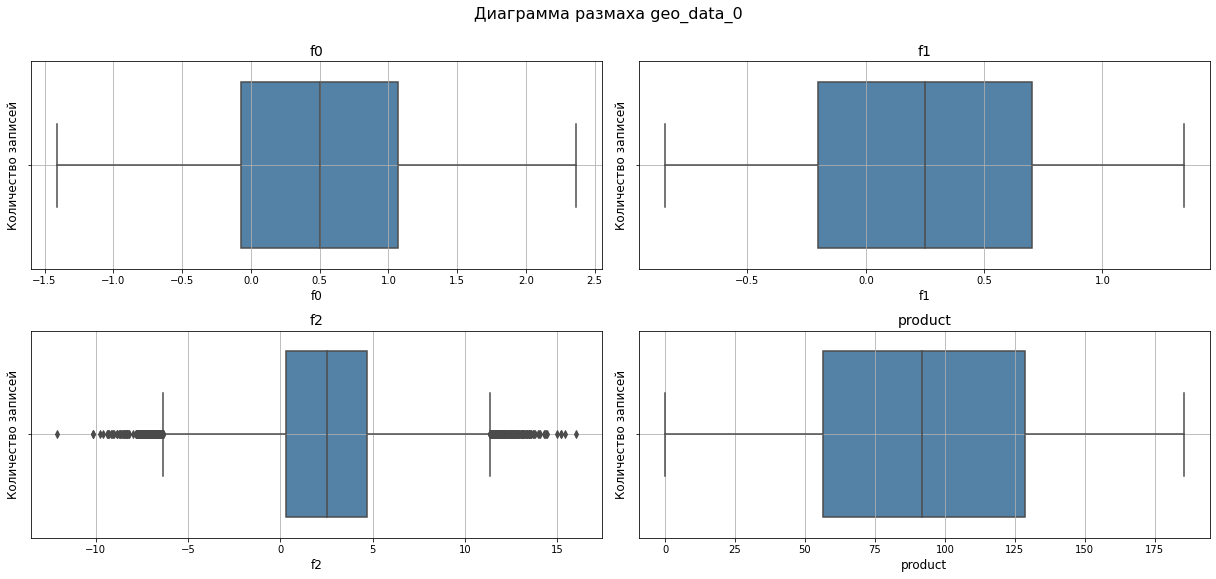

geo_data_1: Медиана признака ['f0'] = 1.1531897893511776
geo_data_1: Медиана признака ['f1'] = -4.813005250314587
geo_data_1: Медиана признака ['f2'] = 2.0114785491201994
geo_data_1: Медиана признака ['product'] = 57.08562464628662


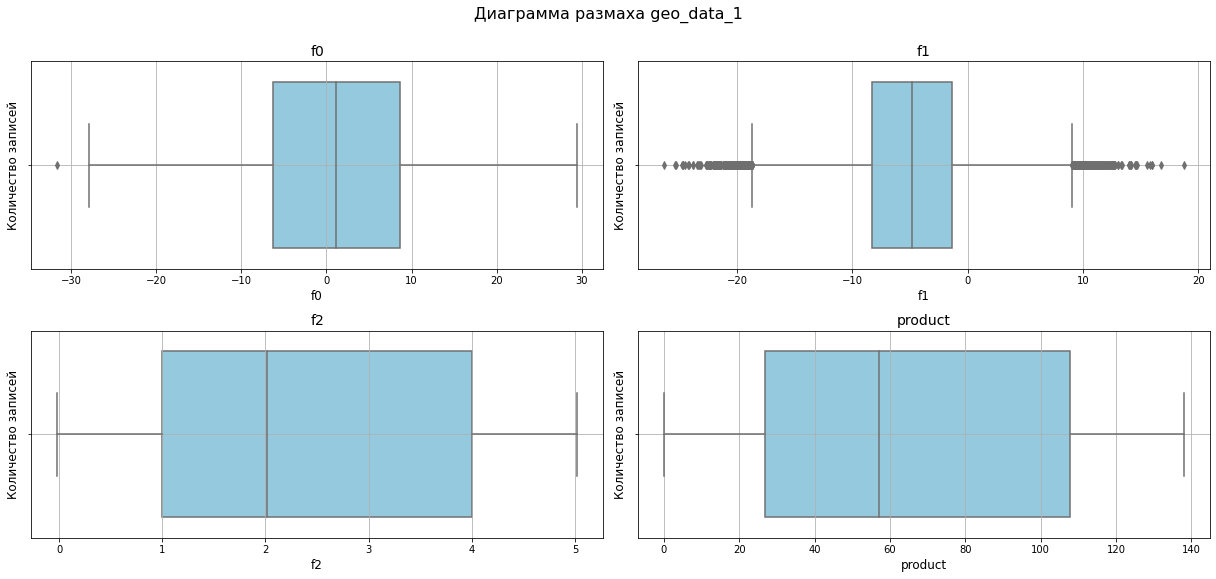

geo_data_2: Медиана признака ['f0'] = 0.00941141587330655
geo_data_2: Медиана признака ['f1'] = -0.009433107089321949
geo_data_2: Медиана признака ['f2'] = 2.4842358439369527
geo_data_2: Медиана признака ['product'] = 94.92561258990247


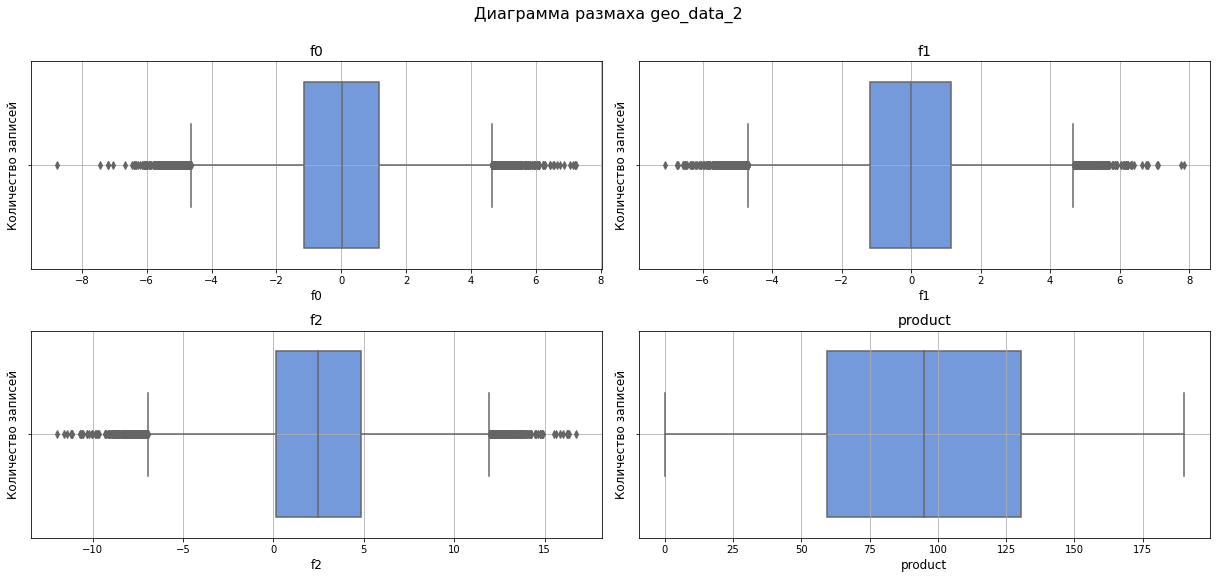

In [27]:
# Построим ящики с усами

# Используем циклы для каждого признака

for j, df in enumerate(df_list):
    fig, axs = plt.subplots(2, 2, figsize=(17, 8))
    axs = axs.flatten()
    fig.suptitle(f'Диаграмма размаха {df_names[j]}', size=16, y=1.0)
    
    for i, feature in enumerate(features):
        sns.boxplot(x=df[feature], ax=axs[i], color=color[j]);
        axs[i].set_title(plot_titles[i], fontsize=14)
        axs[i].set_xlabel(x_labels[i], fontsize=12)
        axs[i].set_ylabel(y_labels[i], fontsize=12)
        axs[i].grid(True)
        print(f'{df_names[j]}: Медиана признака {[feature]} = {np.median(df[feature])}')
    plt.tight_layout()
    plt.show();

В признаках f2 в geo_data_0, f1 в geo_data_1 и f0, f1, f2 в geo_data_2 есть выбросы. 
При этом визуально они максимально похожи на нормально распределенные данны с некоторым смещением.

Посмотрим на выбросы в файлах
(если в дальнейшем, будет необходимо убрать выбросы - посмотрим)

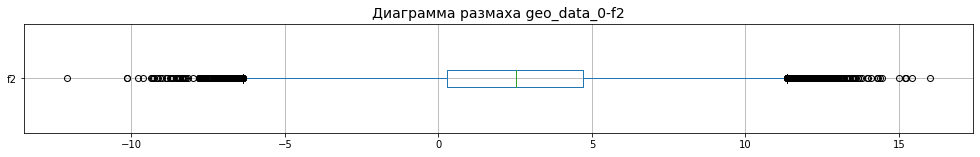

In [28]:
# Построим диаграмму размаха для geo_data_0-f2

fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_0[['f2']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха geo_data_0-f2', size = 14);

In [29]:
# Определим число выбросов в файле geo_data_0 параметре f2

geo_data_0[(geo_data_0['f2']<=-6.25)|(geo_data_0['f2']>= 11.5)]['id'].count()

519

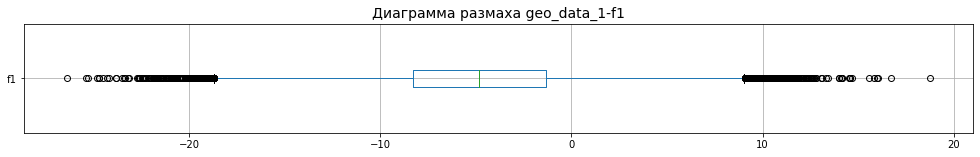

In [30]:
# Построим диаграмму размаха geo_data_1-f1

fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_1[['f1']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха geo_data_1-f1', size = 14);

In [31]:
# Определим число выбросов в файле geo_data_1 параметре f1

geo_data_1[(geo_data_1['f1']<=-19)|(geo_data_1['f1']>= 9)]['id'].count()

592

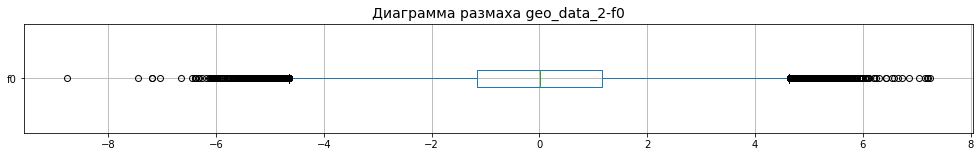

In [32]:
# Построим диаграмму размаха geo_data_1-f0

fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f0']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха geo_data_2-f0', size = 14);

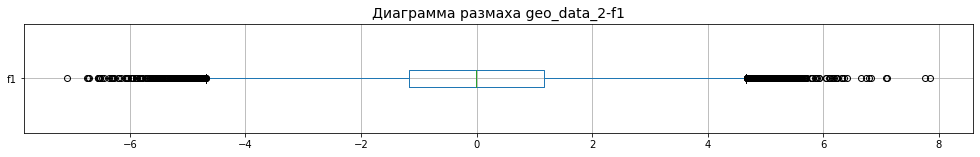

In [33]:
# Построим диаграмму размаха geo_data_1-f1

fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f1']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха geo_data_2-f1', size = 14);

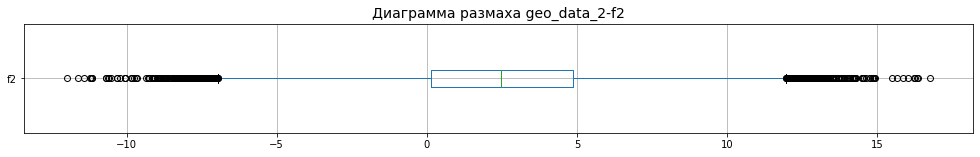

In [34]:
# Построим диаграмму размаха geo_data_1-f2

fig, ax = plt.subplots(figsize = (17,2))
ax = geo_data_2[['f2']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха geo_data_2-f2', size = 14);

In [35]:
# Определим число выбросов в файле geo_data_1 параметре f1

geo_data_2[(geo_data_2['f0']<=-5.4)|(geo_data_2['f0']>= 4.5)]['id'].count()

572

In [36]:
# Определим число выбросов в файле geo_data_1 параметре f1

geo_data_2[(geo_data_2['f1']<=-5.4)|(geo_data_2['f1']>= 4.5)]['id'].count()

557

In [37]:
# Определим число выбросов в файле geo_data_1 параметре f1

geo_data_2[(geo_data_2['f2']<=-7)|(geo_data_2['f2']>= 12)]['id'].count()

567

Проверим нормальность распределения тестами

In [38]:
# Создадим функцию для рассчета коэффициентов распределения признака

def feature_distribution(df, feature):
    print(f'Тест Шапиро-Уилка = {shapiro(df[feature])}')
    if shapiro(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
    print(f'Тест Д Агостино = {normaltest(df[feature])}')
    if normaltest(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
    #print(f'Тест Колмогорова-Смирнова = {kstest(df[feature], "norm")}', '\n')
    
    print(f'Коэффициент асимметрии = {df[feature].skew()}')
    if df[feature].skew() < 0:
        print("Отрицательная асимметрия: хвост находится в левой части.")
        print("Распределение простирается в сторону более отрицательных значений.")
    elif df[feature].skew() == 0:
        print("Нулевая ассиметрия: распределение совершенно симметрично.")
    else:
        print("Положительная асимметрия: хвост находится в правой части.")
        print("Распределение простирается в сторону более положительных значений.")

In [39]:
# Создадим функцию для отображения гистограммы квантиль-квантиль

def feature_qq (df, feature, title):
    fig, axes = plt.subplots(figsize=(8,3))
    fig.suptitle(title, size=16, y=1.03)
    
    qqplot(data=df[feature], ax=axes, line='s')

    plt.title(f'Гистограмма квантиль-квантиль', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    fig.show();    

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.999848484992981, pvalue=8.79792423802428e-06)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=57.85841957612862, pvalue=2.7302588481063847e-13)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = -0.003056981844564485
Отрицательная асимметрия: хвост находится в левой части.
Распределение простирается в сторону более отрицательных значений.


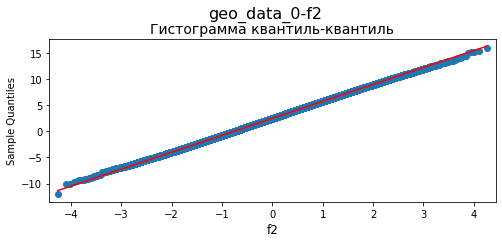

In [40]:
# Проверим распределение признака f2 в файле geo_data_0

feature_qq(geo_data_0, 'f2', "geo_data_0-f2")
feature_distribution(geo_data_0, 'f2')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.9999589920043945, pvalue=0.2638288140296936)
Есть основания полагать, что данные распределены нормально 

Тест Д Агостино = NormaltestResult(statistic=6.826131821114545, pvalue=0.03294005414271119)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 0.01657905356572801
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


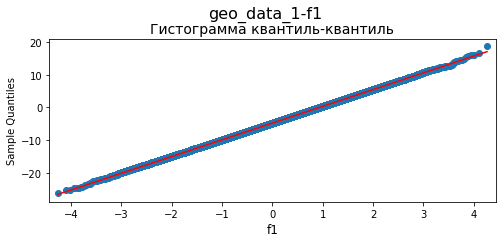

In [41]:
# Проверим распределение признака f1 в файле geo_data_1

feature_qq(geo_data_1, 'f1', "geo_data_1-f1")
feature_distribution(geo_data_1, 'f1')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.9999701380729675, pvalue=0.6016087532043457)
Есть основания полагать, что данные распределены нормально 

Тест Д Агостино = NormaltestResult(statistic=1.2490710396126201, pvalue=0.5355101045990696)
Есть основания полагать, что данные распределены нормально 

Коэффициент асимметрии = 0.003965809724988076
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


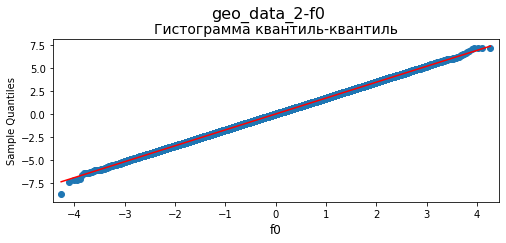

In [42]:
# Проверим распределение признака f0 в файле geo_data_2

feature_qq(geo_data_2, 'f0', "geo_data_2-f0")
feature_distribution(geo_data_2, 'f0')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.9999862909317017, pvalue=0.9925214052200317)
Есть основания полагать, что данные распределены нормально 

Тест Д Агостино = NormaltestResult(statistic=4.257534982549974, pvalue=0.1189838521525787)
Есть основания полагать, что данные распределены нормально 

Коэффициент асимметрии = 0.01476039996973735
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


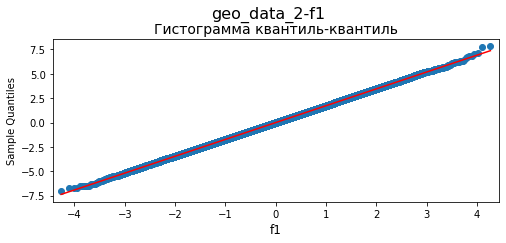

In [43]:
# Проверим распределение признака f1 в файле geo_data_2

feature_qq(geo_data_2, 'f1', "geo_data_2-f1")
feature_distribution(geo_data_2, 'f1')

В данном случае данные распределены максимально нормально, с незначительной ассиметрией вправо.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.9999138712882996, pvalue=0.0033475186210125685)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=20.89181389216718, pvalue=2.9067002959302933e-05)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 0.00407004328184917
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


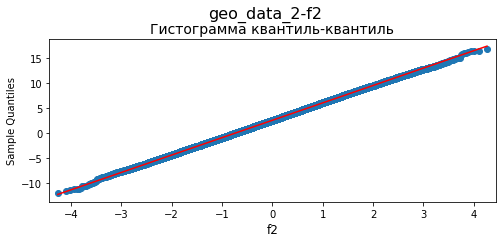

In [44]:
# Проверим распределение признака f2 в файле geo_data_2

feature_qq(geo_data_2, 'f2', "geo_data_2-f2")
feature_distribution(geo_data_2, 'f2')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка = ShapiroResult(statistic=0.9827938675880432, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=12383.668922827055, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 0.00468848206476889
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


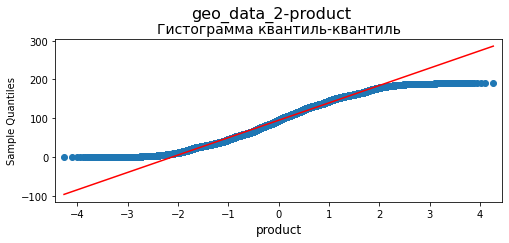

In [45]:
# Для сравнения проверим распределение признака product в файле geo_data_2

feature_qq(geo_data_2, 'product', "geo_data_2-product")
feature_distribution(geo_data_2, 'product')

**Вывод:**

Нормально распределены параметры f0 и f1 в файле geo_data_2

### Корреляционный анализ данных

Хоть большую часть данных занимают "непонятноые" признаки, попробуем выяснить, есть ли между ними корреляция

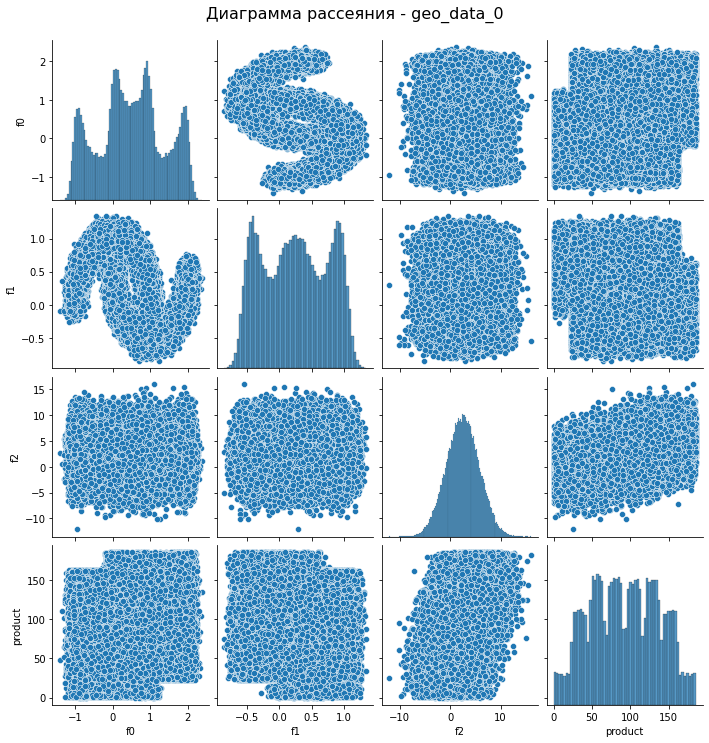

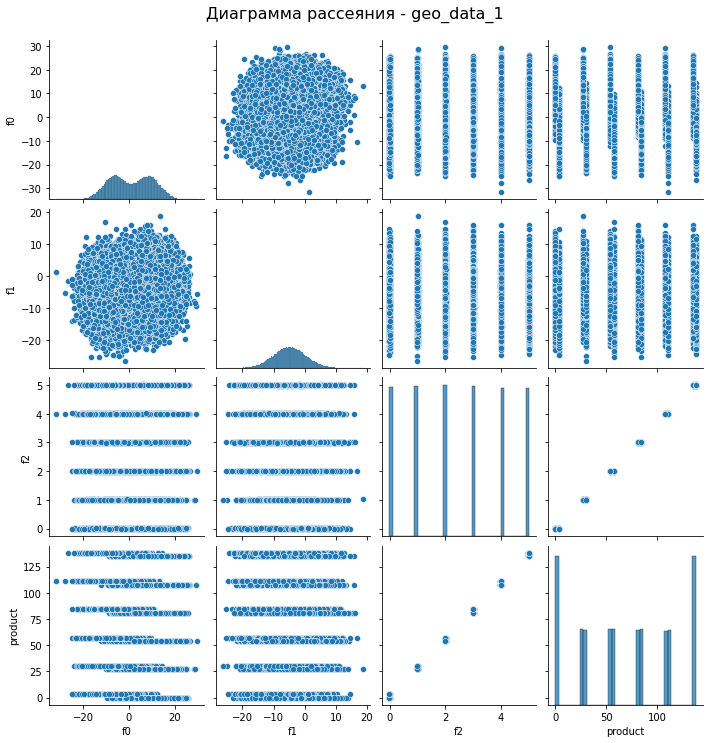

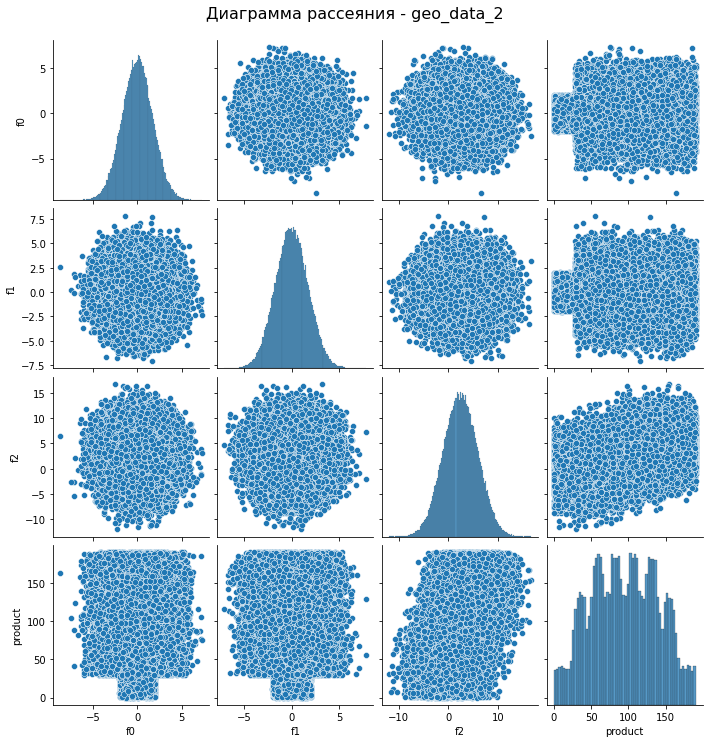

In [46]:
# Построим диаграммы рассеяния

for j, df in enumerate(df_list):
           
    pair_plot = sns.pairplot(data=df.drop('id', axis=1))
                         
    pair_plot.fig.suptitle(f'Диаграмма рассеяния - {df_names[j]}', size=16, y=1.03)
    plt.show();   


Можно отметить некоторую линейную зависимость показателей product и f2, во 2м файле она наиболее четкая.

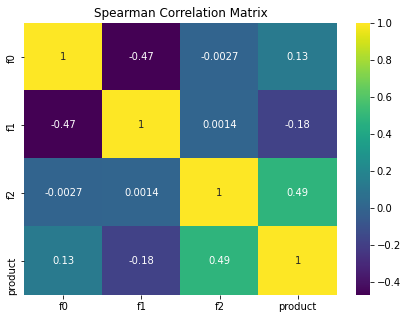

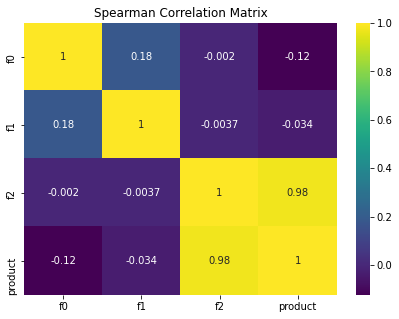

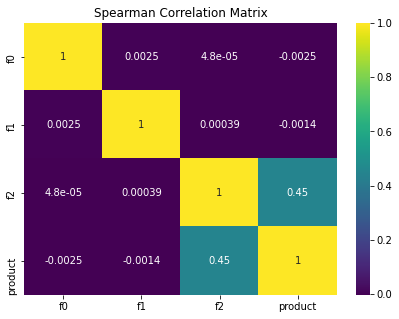

In [47]:
# Матрица корреляции числовых признаков Спирмана
for i, df in enumerate(df_list):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df.corr(method='spearman'), annot=True, cmap='viridis')
    plt.title('Spearman Correlation Matrix');

Мультиколлинеарности не выявлено. 
Во всех 3-х файлах отмечена зависимость product vs f2, но с разной степенью интенсивности. Во 2м файле product практически = f2.

Высокая прямая линйная зависимость в файле geo_data_1: product vs f2, чуть выше среднего: product vs f0
Выше среденего в файле geo_data_0: f0 vs f1, ниже среднего: product vs f2
Ниже среднего в файле geo_data_2: product vs f2

## Обучение и проверка модели

### Подготовка данных для обучения модели

Чтобы не терять id, и не вносить ими излишний шум в модель, сделаем этот показатель индексом

In [48]:
#Сделаем id индексами и сразу проверим результат

for i, df in enumerate(df_list):
    df.set_index(['id'], inplace=True)
    print(df_names[i])
    display(df.head())

geo_data_0


f0     f1    f2  product
id                                
txEyH  0.706 -0.498 1.221  105.280
2acmU  1.335 -0.340 4.365   73.038
409Wp  1.023  0.152 1.420   85.266
iJLyR -0.032  0.139 2.979  168.621
Xdl7t  1.988  0.155 4.752  154.037

geo_data_1


f0      f1     f2  product
id                                   
kBEdx -15.001  -8.276 -0.006    3.179
62mP7  14.272  -3.475  0.999   26.953
vyE1P   6.263  -5.948  5.001  134.766
KcrkZ -13.081 -11.506  4.999  137.945
AHL4O  12.702  -8.147  5.004  134.766

geo_data_2


f0     f1     f2  product
id                                 
fwXo0 -1.147  0.963 -0.829   27.759
WJtFt  0.263  0.270 -2.530   56.070
ovLUW  0.195  0.289 -5.586   62.872
q6cA6  2.236 -0.554  0.930  114.573
WPMUX -0.516  1.716  5.899  149.601

Зададим целевой признак и признаки, которые нужно исключить из выборки. В данном случае они совпадают: Объем запасов в баррелях product.

Подготовим необходимые инструменты для работы модели.

In [49]:
# Определим целевой признак и признаки, которые нужно исключить из выборки

target = 'product'
drop_columns = ['product']

In [50]:
# Создадим функцию для разделения датасета на выборки

def data_split(df, target, drop_columns):
    
    X = df.drop(columns=drop_columns, axis=1)
    y = df[target]
    
    # Для разбивки на 2 выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

Перейдем к подготовке пайплайна. В наших данных только числовые колонки.

In [51]:
# Зададим числовые колонки:

num_code_cols = ['f0', 'f1', 'f2']

In [52]:
# Создаем пайплайн для обработки данных: кодирование и масштабирование

data_preprocessor = ColumnTransformer([('num', StandardScaler(), num_code_cols)], remainder='passthrough') 

Создадим итоговый пайплайн подготовки данных и обучения модели.
В качестве модели возьмем Линейную регрессию (по условию задачи).

In [53]:
# Итоговый пайплайн: подготовка данных и модель (возьмем пока что Логистическую Регрессию)

pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', LinearRegression())]) 

### Обучение модели для региона geo_data_0

In [54]:
# Разобьем файл на выборки

X_train_0, X_test_0, y_train_0, y_test_0 = data_split(geo_data_0, target, drop_columns)

In [55]:
#Проверим размер выборок

print(X_train_0.shape, y_train_0.shape, X_test_0.shape, y_test_0.shape)

(74992, 3) (74992,) (24998, 3) (24998,)


In [56]:
#Обучим модель

pipe_final.fit(X_train_0, y_train_0)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

Оценим качество модели на валидационной выборке

In [57]:
scores = cross_val_score(pipe_final, X_test_0, y_test_0, cv=5, scoring='neg_root_mean_squared_error')

final_score = round((scores.mean()), 4)
print('Средняя метрика модели:', final_score)

Средняя метрика модели: -37.7209


In [58]:
#Расчет остатков

predictions_0 = pipe_final.predict(X_test_0)
residuals_0 = y_test_0 - predictions_0

Медиана остатков = -0.0871
RMSE = 37.7158
Средний запас предсказанного сырья = 92.6287
Средний фактический запас сырья = 92.7035


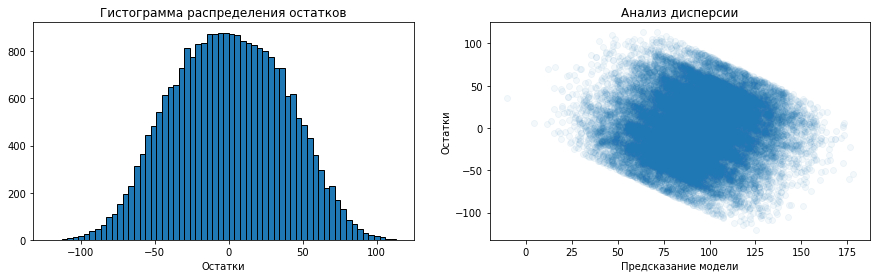

In [59]:
#Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].hist(residuals_0, bins='auto', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_0, residuals_0, alpha=0.05)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

print(f'Медиана остатков = {round(residuals_0.median(), 4)}')
print(f'RMSE = {round(sqrt(mean_squared_error(y_test_0, predictions_0)), 4)}')
print(f'Средний запас предсказанного сырья = {round(predictions_0.mean(),4)}')
print(f'Средний фактический запас сырья = {round(y_test_0.mean(),4)}')

plt.show();

Качество метрики оставляет желать лучшего. Хотя остатки довольно нормально распределены.

In [60]:
# Сохраним выборки с масштабированными колонками

X_train_0_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train_0), columns=data_preprocessor.get_feature_names_out())
X_test_0_pre = pd.DataFrame(data_preprocessor.transform(X_test_0), columns=data_preprocessor.get_feature_names_out())

#### Работа с признаками

Разобьем признак f0 на 4 подгруппы.

In [61]:
# Создадим функцию для категоризации признака f0 файла geo_data_0

def geo_0_f0_cat(row):
    item = row['f0']
    if item <= -0.25:
        return 0
    if item <= 0.5:
        return 1
    if item <= 1.25:
        return 2
    else:
        return 3

In [62]:
geo_data_0['f0_cat'] = geo_data_0.apply(geo_0_f0_cat, axis=1)

In [63]:
# Создадим функцию для категоризации признака f1 файла geo_data_0

def geo_0_f1_cat(row):
    item = row['f1']
    if item <= -0.125:
        return 0
    if item <= 0.625:
        return 1
    else:
        return 2

In [64]:
geo_data_0['f1_cat'] = geo_data_0.apply(geo_0_f1_cat, axis=1)

In [65]:
geo_data_0.head()

f0     f1    f2  product  f0_cat  f1_cat
id                                                
txEyH  0.706 -0.498 1.221  105.280       2       0
2acmU  1.335 -0.340 4.365   73.038       3       0
409Wp  1.023  0.152 1.420   85.266       2       1
iJLyR -0.032  0.139 2.979  168.621       1       1
Xdl7t  1.988  0.155 4.752  154.037       3       1

In [66]:
# Определим целевой признак и признаки, которые нужно исключить из выборки

target_0 = 'product'
drop_columns_0 = ['product', 'f0', 'f1']

In [67]:
# Разобьем файл на выборки

X_train_0_cat, X_test_0_cat, y_train_0_cat, y_test_0_cat = data_split(geo_data_0, target_0, drop_columns_0)

In [68]:
#Проверим размер выборок

print(X_train_0_cat.shape, y_train_0_cat.shape, X_test_0_cat.shape, y_test_0_cat.shape)

(74992, 3) (74992,) (24998, 3) (24998,)


In [69]:
# Зададим числовые колонки:

num_code_cols_0 = ['f2', 'f0_cat', 'f1_cat']

In [70]:
# Создаем пайплайн для обработки данных: кодирование и масштабирование

data_preprocessor_0 = ColumnTransformer([('num', StandardScaler(), num_code_cols_0)], remainder='passthrough') 

Создадим итоговый пайплайн подготовки данных и обучения модели.
В качестве модели возьмем Линейную регрессию (по условию задачи).

In [71]:
# Итоговый пайплайн: подготовка данных и модель (возьмем пока что Логистическую Регрессию)

pipe_0 = Pipeline([('preprocessor', data_preprocessor_0),
                       ('models', LinearRegression())]) 

In [72]:
#Обучим модель

pipe_0.fit(X_train_0_cat, X_train_0_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f2', 'f0_cat',
                                                   'f1_cat'])])),
                ('models', LinearRegression())])

In [73]:
# Оценим качество модели на валидационной выборке

scores = cross_val_score(pipe_0, X_test_0_cat, y_test_0_cat, cv=5, scoring='neg_root_mean_squared_error')

final_score = round(scores.mean(), 4)
print('Средняя метрика модели:', final_score)

Средняя метрика модели: -37.7947


Качество модели не изменилось

Попробуем убрать выбросы признака f2

In [74]:
geo_data_0_excl = geo_data_0[(geo_data_0['f2']>=-10)&(geo_data_0['f2']<=15)]

In [75]:
# Разобьем файл на выборки

X_train_0_cat_excl, X_test_0_cat_excl, y_train_0_cat_excl, y_test_0_cat_excl = data_split(geo_data_0_excl, target, drop_columns)

In [76]:
#Проверим размер выборок

print(X_train_0_cat_excl.shape, y_train_0_cat_excl.shape, X_test_0_cat_excl.shape, y_test_0_cat_excl.shape)

(74986, 5) (74986,) (24996, 5) (24996,)


In [77]:
#Обучим модель

pipe_0.fit(X_train_0_cat, X_train_0_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f2', 'f0_cat',
                                                   'f1_cat'])])),
                ('models', LinearRegression())])

In [78]:
# Оценим качество модели на валидационной выборке

scores = cross_val_score(pipe_0, X_test_0_cat, y_test_0_cat, cv=5, scoring='neg_root_mean_squared_error')

final_score = round(scores.mean(), 4)
print('Среднияя метрика модели:', final_score)

Среднияя метрика модели: -37.7947


Ничего не изменилось, по сравнению с предыдущим вариантом.

Пожалуй, признаки тут бессильны.

In [79]:
# Вернем исходный вид файла

geo_data_0 = geo_data_0.drop(columns=['f0_cat', 'f1_cat'], axis=1)

In [80]:
geo_data_0.head()

f0     f1    f2  product
id                                
txEyH  0.706 -0.498 1.221  105.280
2acmU  1.335 -0.340 4.365   73.038
409Wp  1.023  0.152 1.420   85.266
iJLyR -0.032  0.139 2.979  168.621
Xdl7t  1.988  0.155 4.752  154.037

### Обучение модели для региона geo_data_1

In [81]:
# Разобьем файл на выборки

X_train_1, X_test_1, y_train_1, y_test_1 = data_split(geo_data_1, target, drop_columns)

In [82]:
#Проверим размер выборок

print(X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape)

(74997, 3) (74997,) (24999, 3) (24999,)


In [83]:
#Обучим модель

pipe_final.fit(X_train_1, y_train_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

Оценим качество модели на валидационной выборке

In [84]:
scores = cross_val_score(pipe_final, X_test_1, y_test_1, cv=5, scoring='neg_root_mean_squared_error')

final_score = round(scores.mean(), 4)
print('Средняя метрика модели:', final_score)

Средняя метрика модели: -0.8861


С этим регионом что-то явно не так. Метрика слишком высокая.

In [85]:
#Расчет остатков

predictions_1 = pipe_final.predict(X_test_1)
residuals_1 = y_test_1 - predictions_1

Медиана остатков = -0.0055
RMSE = 0.886
Средний запас предсказанного сырья = 69.0383
Средний фактический запас сырья = 69.031


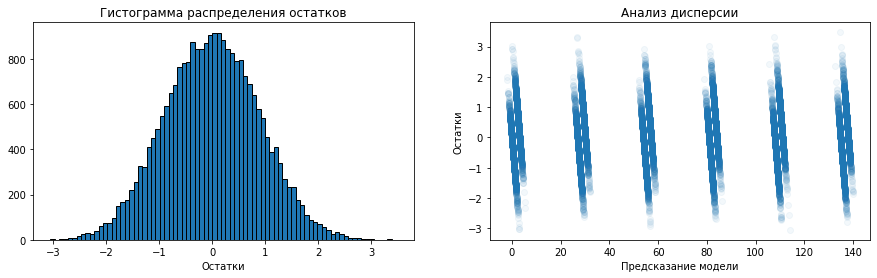

In [86]:
#Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].hist(residuals_1, bins='auto', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1, residuals_1, alpha=0.05)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

print(f'Медиана остатков = {round(residuals_1.median(), 4)}')
print(f'RMSE = {round(sqrt(mean_squared_error(y_test_1, predictions_1)), 4)}')
print(f'Средний запас предсказанного сырья = {round(predictions_1.mean(),4)}')
print(f'Средний фактический запас сырья = {round(y_test_1.mean(),4)}')

plt.show();

Метрика слишком высокая. Нужно поискать ошибки

In [87]:
# Сохраним выборки с масштабированными колонками

X_train_1_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train_1), columns=data_preprocessor.get_feature_names_out())
X_test_1_pre = pd.DataFrame(data_preprocessor.transform(X_test_1), columns=data_preprocessor.get_feature_names_out())

#### Работа с признаками

Попробуем удалить признак f2, который практически совпадает с product, возможно он дает утечку признака.

In [88]:
# Определим целевой признак и признаки, которые нужно исключить из выборки

target_1 = 'product'
drop_columns_1 = ['product', 'f2']

In [89]:
# Разобьем файл на выборки

X_train_1_del, X_test_1_del, y_train_1_del, y_test_1_del = data_split(geo_data_1, target_1, drop_columns_1)

In [90]:
#Проверим размер выборок

print(X_train_1_del.shape, y_train_1_del.shape, X_test_1_del.shape, y_test_1_del.shape)

(74997, 2) (74997,) (24999, 2) (24999,)


In [91]:
# Зададим числовые колонки:

num_code_cols_1 = ['f0', 'f1']

In [92]:
# Создаем пайплайн для обработки данных: кодирование и масштабирование

data_preprocessor_1 = ColumnTransformer([('num', StandardScaler(), num_code_cols_1)], remainder='passthrough') 

Создадим итоговый пайплайн подготовки данных и обучения модели.
В качестве модели возьмем Линейную регрессию (по условию задачи).

In [93]:
# Итоговый пайплайн: подготовка данных и модель (возьмем пока что Логистическую Регрессию)

pipe_1 = Pipeline([('preprocessor', data_preprocessor_1),
                       ('models', LinearRegression())]) 

In [94]:
#Обучим модель

pipe_1.fit(X_train_1_del, y_train_1_del)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1'])])),
                ('models', LinearRegression())])

In [95]:
# Оценим качество модели на валидационной выборке

scores = cross_val_score(pipe_1, X_test_1_del, y_test_1_del, cv=5, scoring='neg_root_mean_squared_error')

final_score = round(scores.mean(), 4)
print('Средняя метрика модели:', final_score)

Средняя метрика модели: -45.8657


In [96]:
#Расчет остатков

predictions_1_del = pipe_1.predict(X_test_1_del)
residuals_1_del = y_test_1_del - predictions_1_del

Медиана остатков = 10.9572
RMSE = 45.8654
Средний запас предсказанного сырья = 68.7537
Средний фактический запас сырья = 69.031


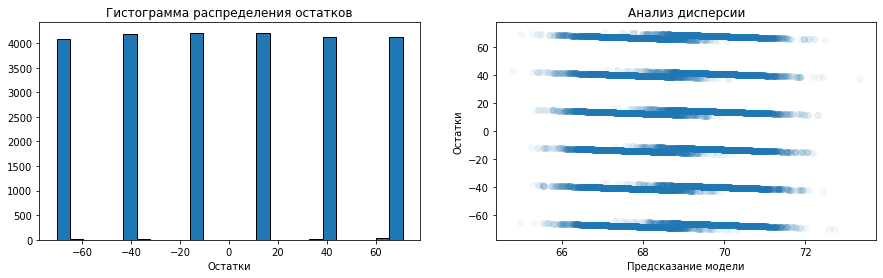

In [97]:
#Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].hist(residuals_1_del, bins='auto', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1_del, residuals_1_del, alpha=0.05)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

print(f'Медиана остатков = {round(residuals_1_del.median(), 4)}')
print(f'RMSE = {round(sqrt(mean_squared_error(y_test_1_del, predictions_1_del)), 4)}')
print(f'Средний запас предсказанного сырья = {round(predictions_1_del.mean(),4)}')
print(f'Средний фактический запас сырья = {round(y_test_1_del.mean(),4)}')

plt.show();

Теперь стало похоже на другие 2е модели.

In [98]:
# Сохраним выборки с масштабированными колонками

X_train_1_del = pd.DataFrame(data_preprocessor_1.fit_transform(X_train_1_del), columns=data_preprocessor_1.get_feature_names_out())
X_test_1_del = pd.DataFrame(data_preprocessor_1.transform(X_test_1_del), columns=data_preprocessor_1.get_feature_names_out())

### Обучение модели для региона geo_data_2

In [99]:
# Разобьем файл на выборки

X_train_2, X_test_2, y_train_2, y_test_2 = data_split(geo_data_2, target, drop_columns)

In [100]:
#Проверим размер выборок

print(X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape)

(74997, 3) (74997,) (24999, 3) (24999,)


In [101]:
#Обучим первую модель

pipe_final.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

Оценим качество модели на валидационной выборке

In [102]:
scores = cross_val_score(pipe_final, X_test_2, y_test_2, cv=5, scoring='neg_root_mean_squared_error')

final_score = round(scores.mean(), 4)
print('Средняя метрика модели:', final_score)

Средняя метрика модели: -39.9369


In [103]:
#Расчет остатков

predictions_2 = pipe_final.predict(X_test_2)
residuals_2 = y_test_2 - predictions_2

Медиана остатков = 0.5734
RMSE = 39.9411
Средний запас предсказанного сырья = 94.7112
Средний фактический запас сырья = 95.308


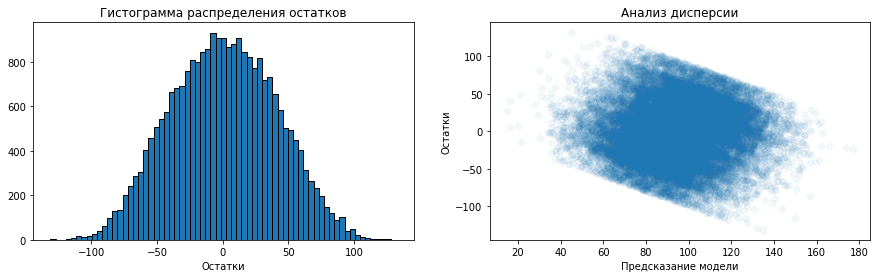

In [104]:
#Анализ остатков: графики по количественным признакам гистограмма и boxplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].hist(residuals_2, bins='auto', edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals_2, alpha=0.05)
axes[1].set_xlabel('Предсказание модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

print(f'Медиана остатков = {round(residuals_2.median(), 4)}')
print(f'RMSE = {round(sqrt(mean_squared_error(y_test_2, predictions_2)), 4)}')
print(f'Средний запас предсказанного сырья = {round(predictions_2.mean(),4)}')
print(f'Средний фактический запас сырья = {round(y_test_2.mean(),4)}')

plt.show();

Распределение довольно равномерно.

In [105]:
# Сохраним выборки с масштабированными колонками

X_train_2_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train_2), columns=data_preprocessor.get_feature_names_out())
X_test_2_pre = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

Выведем результаты по всем трем регионам в таблице

In [106]:
# Создадим DataFrame

columns = ['geo_data_0', 'geo_data_1', 'geo_data_1_del', 'geo_data_2']
index = ['RMSE', 'predictions_mean', 'actuals_mean']

data = {
    'geo_data_0': [
        round(sqrt(mean_squared_error(y_test_0, predictions_0)), 4),
        round(predictions_0.mean(),4),
        round(y_test_0.mean(),4),
    ], 
    'geo_data_1': [
        round(sqrt(mean_squared_error(y_test_1, predictions_1)), 4),
        round(predictions_1.mean(),4),
        round(y_test_1.mean(),4)        
    ], 
    'geo_data_1_del': [
        round(sqrt(mean_squared_error(y_test_1_del, predictions_1_del)), 4),
        round(predictions_1_del.mean(),4),
        round(y_test_1_del.mean(),4)        
    ], 
    'geo_data_2': [
        round(sqrt(mean_squared_error(y_test_2, predictions_2)), 4),
        round(predictions_2.mean(),4),
        round(y_test_2.mean(),4)        
    ]
} 

res = pd.DataFrame(index=index, data=data)

In [107]:
res

geo_data_0  geo_data_1  geo_data_1_del  geo_data_2
RMSE                  37.716       0.886          45.865      39.941
predictions_mean      92.629      69.038          68.754      94.711
actuals_mean          92.704      69.031          69.031      95.308

**Вывод:**

По запасу предсказанного сырья лидирует 3й регион (geo_data_2) = 94 тыс. баррелей, на 2м месте 1й регион (geo_data_0) = 92 тыс. баррелей, на 3м - 2й регион (geo_data_1) = 69 тыс. баррелей.

Однако, метрика RMSE и анализ остатков показывает, что наиболее точно модель предсказывает данные во 2м регионе - RMSE составляет всего 0,88 (отклонение предсказанного значения от реального). В остальных случаях = 37 (geo_data_0) и 39 (geo_data_2)

## Подготовка к расчёту прибыли

Сохраним вводные для расчета прибыли

In [108]:
# Количество скважин при разведке региона
OIL_WELL_NUM = 500

# Количество скважин для разработки
OIL_WELL_DEVELOPMENT_NUM = 200

# Бюджет на разработку скважин в регионе
BUDGET = 10000000000

# Доход с каждой единицы продукта, тыс.руб.
BARREL_REVENUE_TR = 450000

# Максимальная граница вероятности убытков 
P_LOSS_LIMIT = 0.025

Рассчитаем точку безубыточности для одной скважины.
Для этого выделенный объем инвестиций (бюджет на разработку) разделим на доход с каждой единицы продукта - получим объем нефти, который нужно добыть из 200 разрабатываемых скважин.
Это количество разделим на 200 и получим объем нефти, который должен быть добыт из одной скважины.

In [109]:
break_even_point_value = round((BUDGET / BARREL_REVENUE_TR / OIL_WELL_DEVELOPMENT_NUM),4)
break_even_point_value

111.1111

Т.о. объем нефти в скважине должен быть не менее 111 тыс. баррелей

Посмотрим, на каком уровне находятся значения объемов нефти = точке безубыточности в 3-х регионах

In [110]:
# Вспомним описание данных

for i, df in enumerate(df_list):
    print(df_names[i])
    display(df['product'].describe())

geo_data_0


count   99990.000
mean       92.499
std        44.289
min         0.000
25%        56.497
50%        91.850
75%       128.564
max       185.364
Name: product, dtype: float64

geo_data_1


count   99996.000
mean       68.825
std        45.945
min         0.000
25%        26.953
50%        57.086
75%       107.813
max       137.945
Name: product, dtype: float64

geo_data_2


count   99996.000
mean       95.000
std        44.748
min         0.000
25%        59.452
50%        94.926
75%       130.591
max       190.030
Name: product, dtype: float64

Средние значения прибыли не достигают точки безубыточности ни в одном регионе. Для разработки требуется отбирать скважины с максимальными объемами нефти.

На уровне 75% точка безубыточности достигнута в регионе 1 и 3, и от 75 до 100% - в регионе 2. 

Т.е. примерно 20-25% скважин соответствуют условию.

In [111]:
# Можно посмотреть поточнее

quantile = [0.6, 0.61, 0.62, 0.63, 0.64, 0.82, 0.83, 0.84, 0.85]
for i, df in enumerate(df_list):
    print(df_names[i])
    for j in quantile:
        val = df['product'].quantile(j)
        if val >= break_even_point_value:
            print(f'{100-j*100}% скважин содержат объем нефти = {df["product"].quantile(j)}', '\n')
            break

geo_data_0
36.0% скважин содержат объем нефти = 111.87230437498957 

geo_data_1
16.0% скважин содержат объем нефти = 134.76630515769844 

geo_data_2
38.0% скважин содержат объем нефти = 111.33683727723755 



## Расчет прибыли и рисков

### Функция для расчета прибыли

In [112]:
# Создадим таблицы с фактическими данными, предсказаниями и индексами для каждого региона

# регион 1
df_pred_0 = pd.DataFrame({'y_test': y_test_0, 'predictions': predictions_0})
# регион 2
df_pred_1 = pd.DataFrame({'y_test': y_test_1, 'predictions': predictions_1})
# регион 2 без признака f2
df_pred_1_del = pd.DataFrame({'y_test': y_test_1_del, 'predictions': predictions_1_del})
# регион 3
df_pred_2 = pd.DataFrame({'y_test': y_test_2, 'predictions': predictions_2})

In [113]:
# Выборочно проверим, что получилось

df_pred_0.head()

y_test  predictions
id                        
564GV  30.740       77.788
rvuU3  48.772      110.993
TNo8V 135.776      101.847
JBKAy  35.974       63.460
2zTOA  87.794       42.494

In [114]:
# Создадим список новых файлов

pred_list_index = [df_pred_0, df_pred_1, df_pred_1_del, df_pred_2]
pred_list_names = ['geo_data_0', 'geo_data_1', 'geo_data_1 без f2', 'geo_data_2']

In [122]:
# Создадим функцию для расчета прибыли

def revenue_calc(target, pred):
    
    # Отсортируем предсказания модели по убыванию
    pred_soreted = pred.sort_values(ascending=False)
    
    # Отберем фактические значения объемов нефти по индексам из предсказаний, количество = разрабатываемым скважинам = 200
    selected = target[pred_soreted.index][:OIL_WELL_DEVELOPMENT_NUM]
    
    # Выручка = сумма всех тобранных истинных значений * стоимость тыс.баррелей нефти
    revenue = (sum(selected)*BARREL_REVENUE_TR)
    
    # Прибыль = выручка - инвестиции в разработку региона
    profit = revenue - BUDGET
    
    return (revenue, profit)  

Чтобы отобрать скважины, нам потребуются индексы элементов

In [123]:
# Рассчитаем прибыльность каждого региона

for i, df in enumerate(pred_list_index):
    
    # Выручка
    revenue = round(revenue_calc(pred_list_index[i]['y_test'], pred_list_index[i]['predictions'])[0])
    
    # Прибыль
    profit = round(revenue_calc(pred_list_index[i]['y_test'], pred_list_index[i]['predictions'])[1])
    
    print(f'Прибыль от разработки {OIL_WELL_DEVELOPMENT_NUM} скважин в регионе {pred_list_names[i]}: {profit}')
    print(f'Маржинальность: {round((profit / revenue ), 3)*100}')
    print(f'ROI: {round(((profit - BUDGET)/ BUDGET),3)*100}','\n')

Прибыль от разработки 200 скважин в регионе geo_data_0: 3077564429
Маржинальность: 23.5
ROI: -69.19999999999999 

Прибыль от разработки 200 скважин в регионе geo_data_1: 2415086697
Маржинальность: 19.5
ROI: -75.8 

Прибыль от разработки 200 скважин в регионе geo_data_1 без f2: -3734299808
Маржинальность: -59.599999999999994
ROI: -137.3 

Прибыль от разработки 200 скважин в регионе geo_data_2: 2660141150
Маржинальность: 21.0
ROI: -73.4 



**Вывод:**

Если в каждом регионе выбрать 200 скважин с максимальным объемом запасо, то показатели маржинальности и окупаемости инвестиций наибольшие в 1м регионе, наименьшие во 2м регионе.

Если взять данные 2го региона без признака f2, то здесь получается даже убыток.

### Расчет прибыли и рисков

Посчитайте риски и прибыль для каждого региона:
 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [124]:
# Зададим случайный RandomState

state = np.random.RandomState(12345)

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, доверительный интервал и вероятность убытков

In [125]:
def revenue_interval(df, df_name):
    # Создадим пустой список для хранения показателей прибыли
    values = []
    
    # И список для отрицательных показателей прибыли (убытков)
    loss = []
    
    # Bootstrap применим в цикле
    for i in range(1000):
        
        # Выбираем 500 скважин
        preds_subsample = df.predictions.sample(n=500, replace=True, random_state=state)
        y_true_subsample = df.y_test[preds_subsample.index]
        
        # С помощью функции рассчитываем прибыль для 200т скважин с максимальным объемом нефти
        # Добавляем это значение в список
        profit = revenue_calc(y_true_subsample, preds_subsample)[1]
        values.append(profit) 
        
        # Если значение отрицательное, добавляем его в убыток
        if profit < 0:
            loss.append(profit)
            
    # Переводим список в тип Series
    values = pd.Series(values)
        
    # Находим квантиль, соответствующий наименьшим 2.5% прибыли
    lower = round(values.quantile(0.025)) 
        
    # Находим квантиль, соответствующий наибольшим 2.5% прибыли
    upper = round(values.quantile(0.975)) 
        
    # Находим среднее значение прибыли
    mean = round(values.mean())

    # Найдем вероятность убытков
    loss_probability = round(len(loss)/len(values),4)*100
     
    #loss_probability = round((values < 0).mean(),4)*100
    
    print(f'{df_name}:')
    print("Средняя прибыль:", mean)
    print(f'95%й Доверительный интервал составляет от {lower} до {upper}')
    print(f'Вероятность убытков {loss_probability}%', '\n')
    if loss_probability < 2.5:
        print(f'Регион соответствует критерию прибыльности (вероятность убытков меньше 2,5%)')
    else:
        print(f'Регион НЕ соответствует критерию прибыльности (вероятность убытков больше 2,5%)')
        
    fig = px.histogram(
        values, title=("Распределение прибыли 200 отобранных моделью скважин с максимальным объемом нефти"), height=500
    )
    fig.add_vline(x=0, line_width=1.5, line_dash="dash", line_color="red")
    fig.add_vline(x=mean, line_width=3, line_dash="dash", line_color="blue",
                  annotation_text=(f'Средняя прибыль {mean}'), annotation=dict(font_size=16)),
    fig.add_vrect(x0=lower, x1=upper, 
              annotation_text="Доверительный интервал", annotation_position="bottom",
              annotation=dict(font_size=16),
              fillcolor="lightblue", opacity=0.25, line_width=0.5)
    
    fig.show()

In [126]:
for i, df in enumerate(pred_list_index):
    revenue_interval(df, pred_list_names[i])
    #print('\n')

geo_data_0:
Средняя прибыль: 473937160
95%й Доверительный интервал составляет от -53346857 до 1035391514
Вероятность убытков 4.2% 

Регион НЕ соответствует критерию прибыльности (вероятность убытков больше 2,5%)


geo_data_1:
Средняя прибыль: 510397808
95%й Доверительный интервал составляет от 103793767 до 938871622
Вероятность убытков 0.8% 

Регион соответствует критерию прибыльности (вероятность убытков меньше 2,5%)


geo_data_1 без f2:
Средняя прибыль: -3611105201
95%й Доверительный интервал составляет от -4198097529 до -3013607446
Вероятность убытков 100.0% 

Регион НЕ соответствует критерию прибыльности (вероятность убытков больше 2,5%)


geo_data_2:
Средняя прибыль: 436954410
95%й Доверительный интервал составляет от -130321344 до 974352437
Вероятность убытков 6.2% 

Регион НЕ соответствует критерию прибыльности (вероятность убытков больше 2,5%)


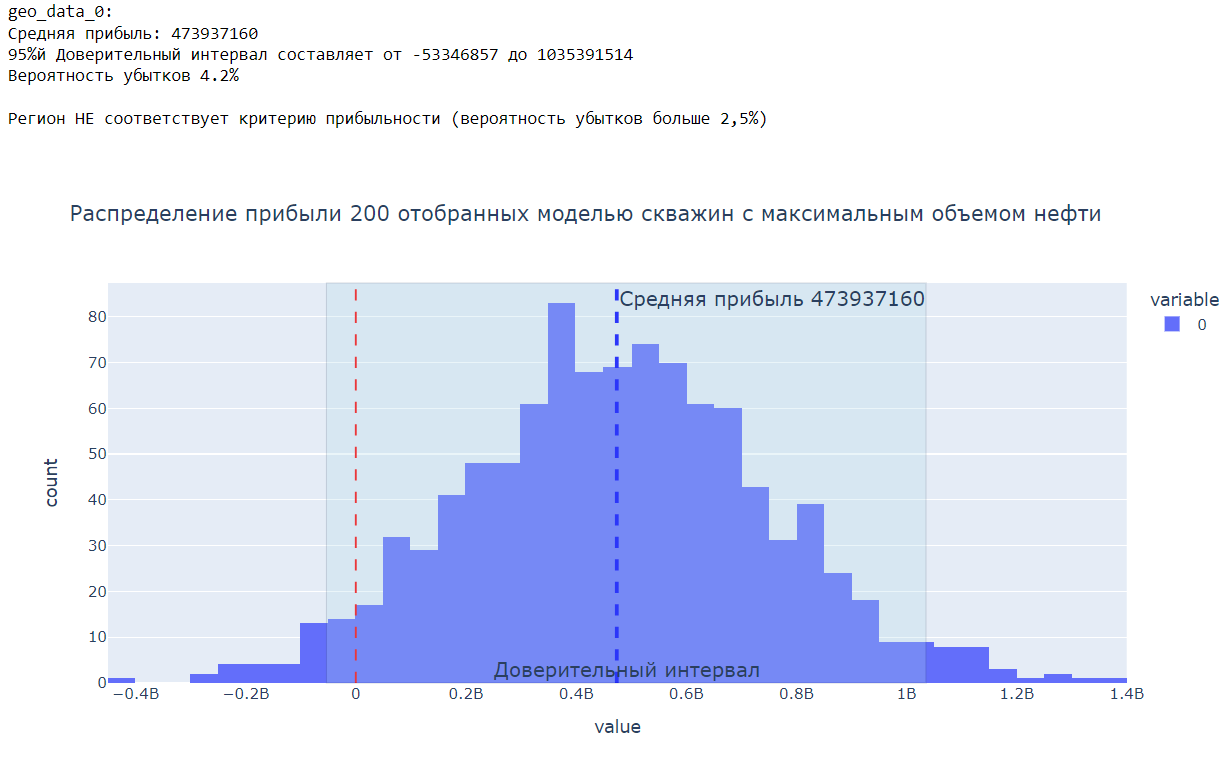

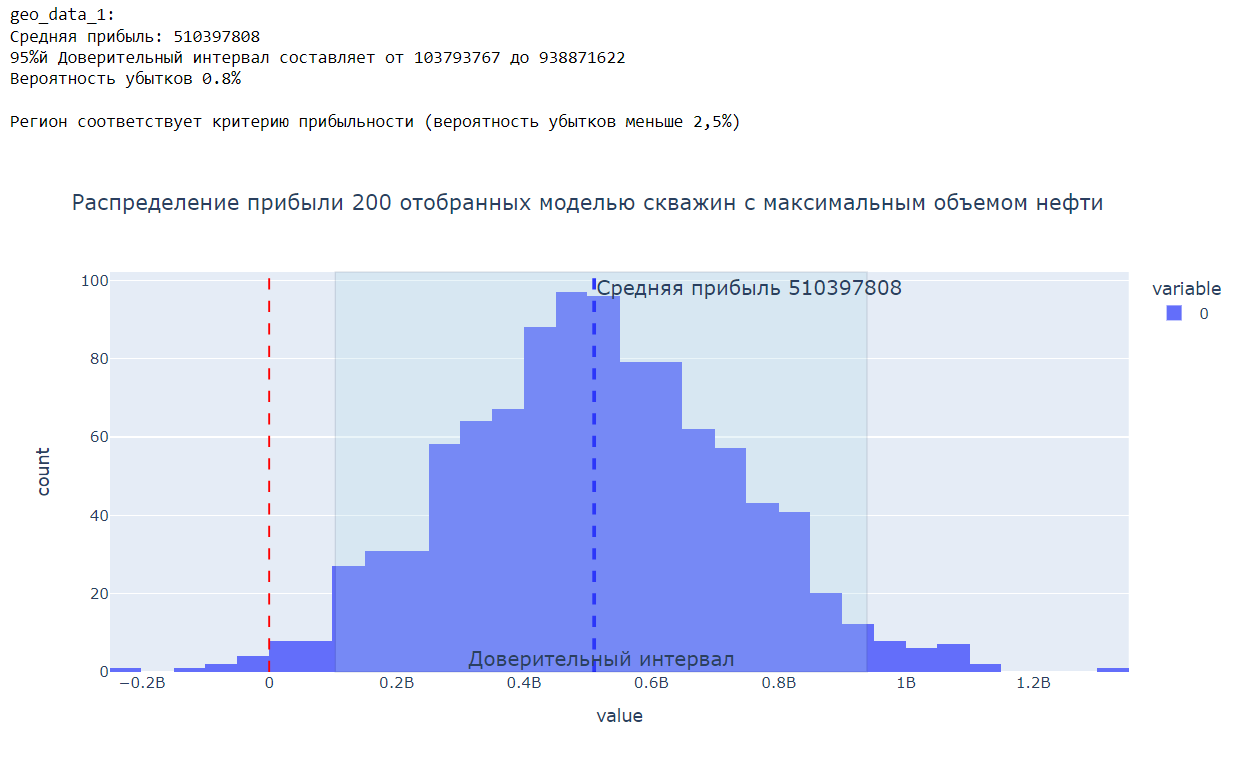

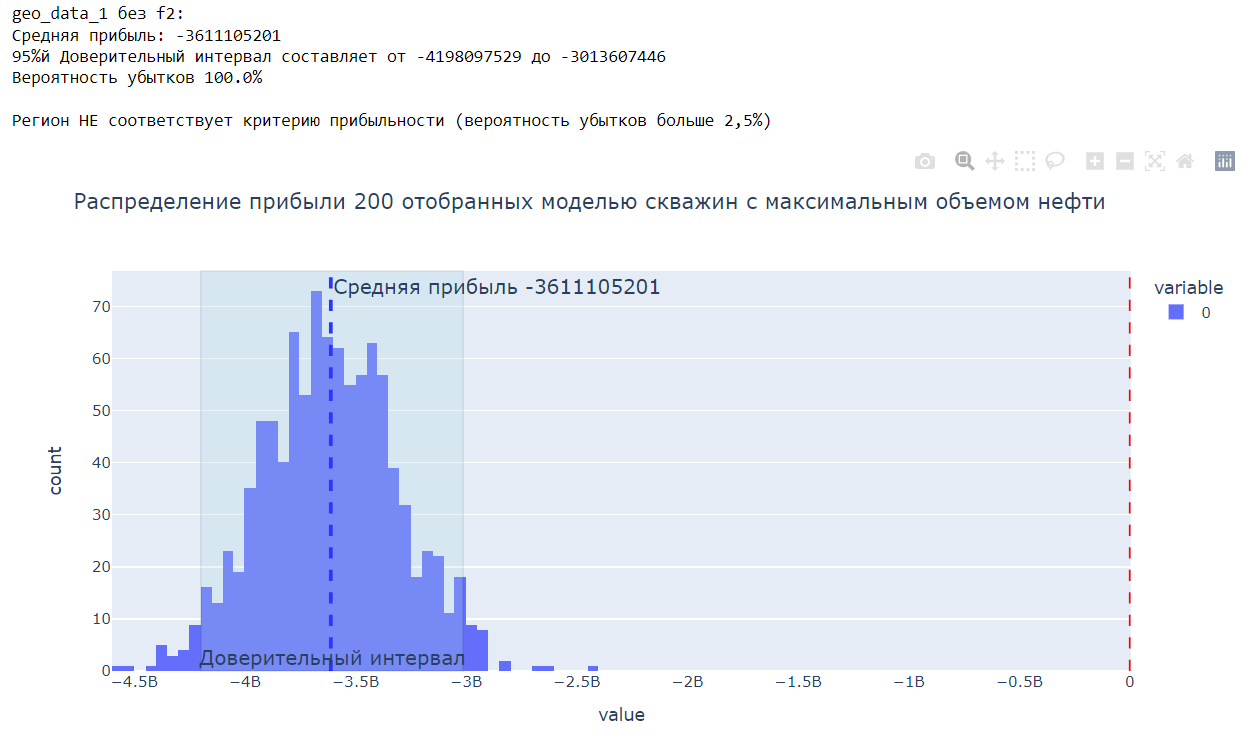

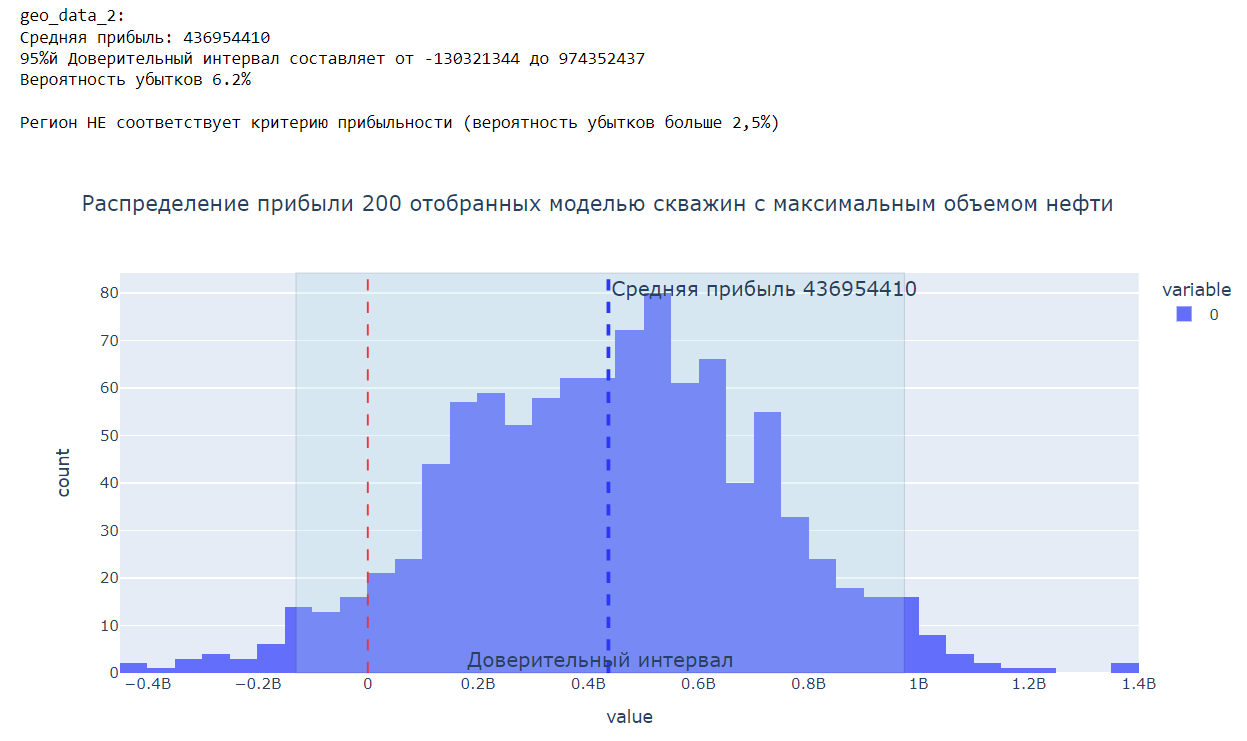

Получается, что для региона 2 следует все же удалить признак f2, поскольку с ним значения совсем отрованы от реальности.

Т.о. Оптимальным регионом является регион 1: здесь наибольшие показатели средней прибыли и наименьшая вероятность убытков. При этом по запасам сырья он на 2м месте.

**Вывод:**

Получается, что все регионы не соответствуют критерию прибыльности (вероятность убытков выше 2,5%).

При этом наибольшая средняя прибыль в регионе 1.

## Общий вывод

Представленные исходные данные корректны: названия колонок на латинице, типы данных соответствуют заявленным, пропусков и аномальных значений нет. В наблюдениях есть выбросы, но поскольку нам не известно, что это за показатели, они сохранены. 

**Важно: есть дубликаты по id.** Хотя число их крайне ничтожно, но в дальнейшем следует избегать подобных недостатков в наблюдениях. Возможно, это уточненные данные.
Во избежание путаницы, дубликаты удалены.

Исследовано распределение данных: часть данных имеют нормальное распределение, что показывают тесты Шапиро-Уилка, Д'Агостино, графики квантиль-квантиль и гистограммы распределения признаков.
Диаграммы рассеяния показывают зависимость признака f2 и  product, по остальным нет явной линейной зависимости. 
Поскольку зависимость не четкая линейная, а признаки только числовые, матрица корреляций построена с коэффициентами Спирмана.
**Во 2м регионе корреляция f2 и product 0,98**, т.е. признаки практически равнозначны. 
В дальшейм для модели будут использованы данные 2го файла за вычетом f2, чтобы избежать утечки целевого признака.

Для работы модели (кодирование признаков) был использован пайплайн. Модель: Линейная регрессия (по условию задачи).

Были обучены модели на исходных данных. Затем проведена работа по подбору признаков: категоризация признаков не дала результата. А вот удаление признака f2 для 2го региона привело модель к более адекватным результатам. В дальнейшем эти данные будем использовать, как основные для региона 2, а исходные - для сравнения.

Средние предсказанные значения объемов запасов практически совпадают с реальными средними запасами по каждому региону. Метрика RMSE минимальна в первом регионе (37,7) и максимальна во 2м регионе без f2 (45,9). Т.е. модель показывает лучшие предсказания на регионе 1.

При подготовке к расчету прибыли базовые параметры расчетов сохранены в переменных.
Рассчитана точка безубыточности как объем запасов одной скважины, которая составила 111,11 тыс. баррелей.

Определено, что точке безубыточности соответствуют: 36% скважин в первом регионе, 16% скважин во 2м реионе, 38% скважин в 3м регионе.

С примененим функции рассчитаны:
* Прибыль от разработки 200 скважин в каждом регионе: максимальная в регионе 1, в регионе 2 - убытки;
* Маржинальность по регионам, соотв-но: 23,5%, -59,6%, 21%
* ROI: -69,2%, -137,3%Б -73,4%

По данным показателям лучшие резултаты показывает регион 1, регион 2 - убыточен и показывает худшие результаты из 3х регионов.

С применением функций и техники Bootstrap с 1000 выборок рассчитаны:
* Распределение прибыли: средняя прибыль максимальна в регионе 1, в регионе 2 - убытки.
* 95%й Доверительный интервал: оптимальный для региона 1
* Вероятность убытков: минимальная величина в регионе 1, в регионе 2 - 100%.

При этом заданному критерию: вероятность убытков 2,5%, не соответствует ни один регион.

**Общая рекомендация:**

Снизив критерий "вероятность убытков" до 3,5-4%, **в качестве оптимального следует выбрать регион 1**.
Здесь отмечены 2е по объему запасы продукта, максимальный расчетный показатель прибыли и минимальные расчетные показатели вероятности убытков.